In [20]:
import os
import pathlib
import pandas as pd

import seaborn as sns

In [21]:
DATA_FILE_PATH = pathlib.Path(os.getcwd()) / "csv_files" / "diabetes.csv"
MODEL_SAVE_PATH = pathlib.Path(os.getcwd()) / "model_states" / "pyt_diabetes.pth"

df = pd.read_csv(DATA_FILE_PATH, index_col=0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

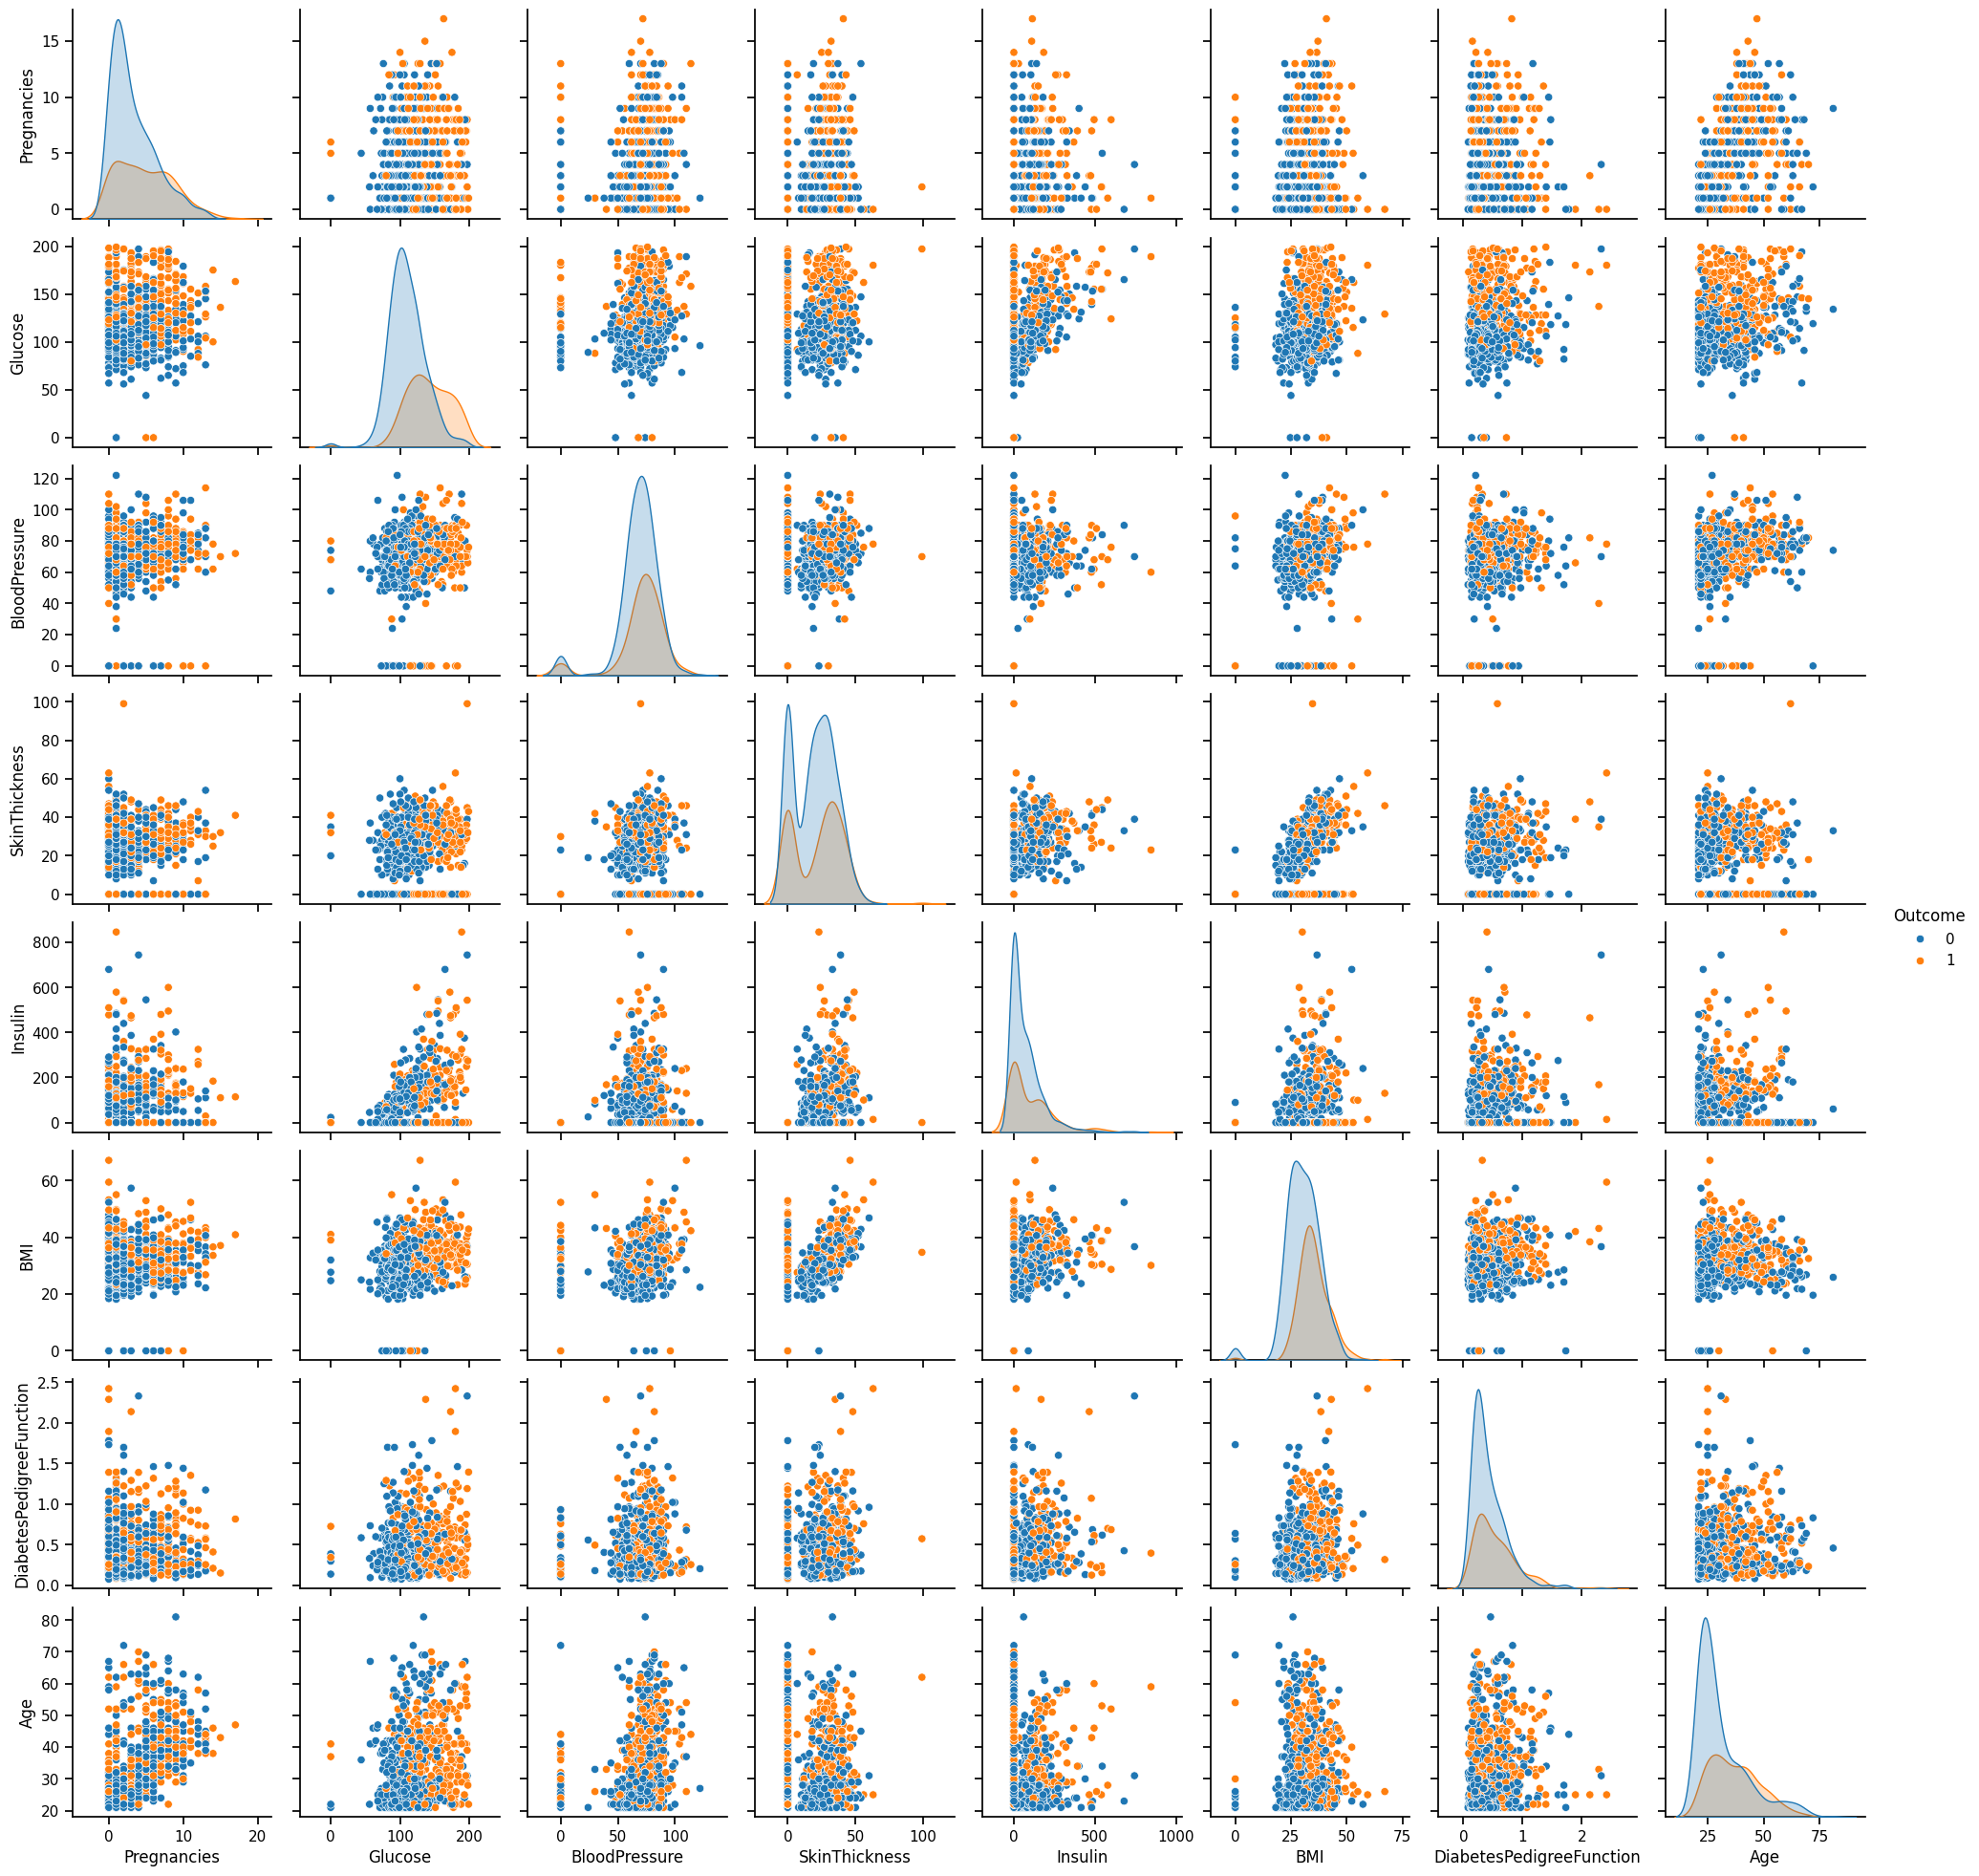

In [23]:
sns.pairplot(df, hue="Outcome")

In [24]:
X = df.drop(["Outcome"], axis=1).values
y = df["Outcome"].values
type(X), type(y), X.shape, y.shape

(numpy.ndarray, numpy.ndarray, (768, 8), (768,))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=20
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=20
)

print(
    f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - "
    f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - "
    f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}"
)

X_train.shape: (552, 8) - y_train.shape: (552,) - X_val.shape: (139, 8) - y_val.shape: (139,) - X_test.shape: (77, 8) - y_test.shape: (77,)


In [26]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_val_std = ss.fit_transform(X_val)
X_test_std = ss.transform(X_test)

In [27]:
import torch
import torch.nn as nn
import torchmetrics
import torchsummary

import torch_training_toolkit as t3

SEED = t3.seed_all(20)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
class ANN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANN_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [29]:
INPUT_DIM, HIDDEN_DIM, NUM_CLASSES = X_train.shape[1], 15, 2

In [30]:
model = ANN_Model(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
print(torchsummary.summary(model, (INPUT_DIM,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]             135
              ReLU-2                   [-1, 15]               0
            Linear-3                   [-1, 15]             240
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 2]              32
Total params: 407
Trainable params: 407
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
None


In [31]:
model.parameters

<bound method Module.parameters of ANN_Model(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)>

In [32]:
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 500, 32, 0.001, 0.01
MODEL_SAVE_DIR = os.path.join(".", "model_states")

In [33]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn=loss_fn,
    device=DEVICE,
    metrics_map=metrics_map,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

In [34]:
hist = trainer.fit(
    model,
    optimizer,
    train_dataset=(X_train_std, y_train),
    validation_dataset=(X_val_std, y_val),
    reporting_interval=10,
    seed=SEED,
)

Cross training on 'cpu' with 552 training and 139 cross-validation records...
NOTE: progress will be reported every 10 epoch!
Epoch (  1/500): (552/552) -> loss: 0.7093 - acc: 0.5198 - val_loss: 0.6860 - val_acc: 0.6245
Epoch ( 10/500): (552/552) -> loss: 0.5338 - acc: 0.6628 - val_loss: 0.4936 - val_acc: 0.7012
Epoch ( 20/500): (552/552) -> loss: 0.4475 - acc: 0.7293 - val_loss: 0.4379 - val_acc: 0.7739
Epoch ( 30/500): (552/552) -> loss: 0.4567 - acc: 0.7258 - val_loss: 0.4549 - val_acc: 0.6763
Epoch ( 40/500): (552/552) -> loss: 0.4455 - acc: 0.7242 - val_loss: 0.4842 - val_acc: 0.7330
Epoch ( 50/500): (552/552) -> loss: 0.4381 - acc: 0.7136 - val_loss: 0.4689 - val_acc: 0.7323
Epoch ( 60/500): (552/552) -> loss: 0.4413 - acc: 0.7332 - val_loss: 0.5022 - val_acc: 0.7313
Epoch ( 70/500): (552/552) -> loss: 0.4276 - acc: 0.7364 - val_loss: 0.4538 - val_acc: 0.7520
Epoch ( 80/500): (552/552) -> loss: 0.4192 - acc: 0.7474 - val_loss: 0.4466 - val_acc: 0.7916
Epoch ( 90/500): (552/552) -

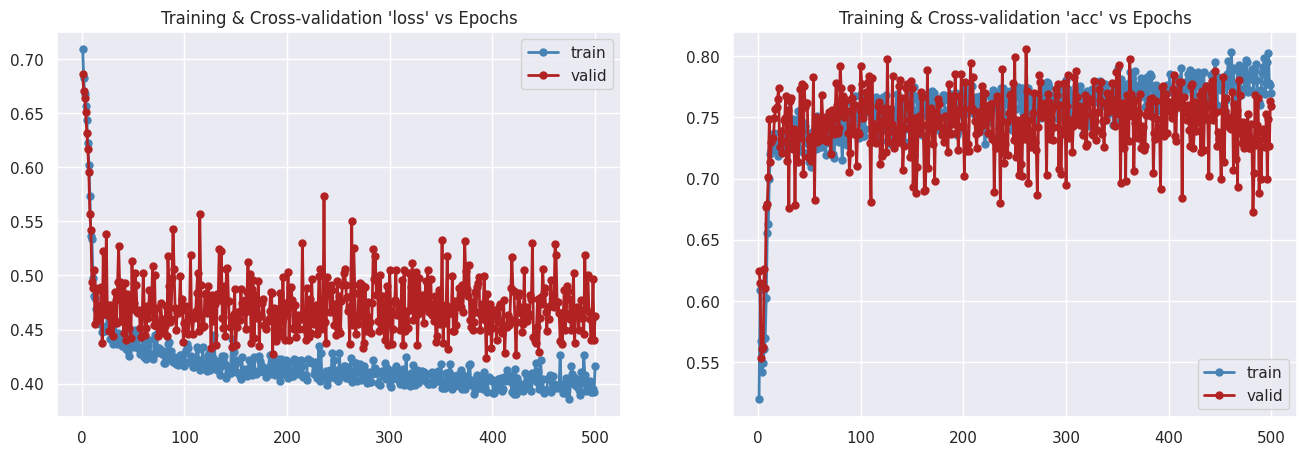

In [35]:
hist.plot_metrics()

In [39]:
# evaluate performance
print("Evaluating model performance...")
metrics = trainer.evaluate(model, (X_train_std, y_train))
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, (X_val_std, y_val))
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, (X_test_std, y_test))
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (552/552) -> loss: 0.2523 - acc: 0.9000('\rEvaluating (552/552) -> loss: 0.3902 - acc: 0.8021',)
Training metrics -> loss: 0.3902 - acc: 0.8021
Evaluating (139/139) -> loss: 0.4182 - acc: 0.8036('\rEvaluating (139/139) -> loss: 0.4657 - acc: 0.7510',)
Cross-val metrics -> loss: 0.4657 - acc: 0.7510
Evaluating (77/77) -> loss: 0.1665 - acc: 1.0000('\rEvaluating (77/77) -> loss: 0.4783 - acc: 0.7388',)
Testing metrics   -> loss: 0.4783 - acc: 0.7388


In [37]:
t3.save_model(model, MODEL_SAVE_PATH)
del model

Pytorch model saved to /home/mjbhobe/code/git-projects/dl-pytorch/model_states/pyt_diabetes.pth


In [38]:
model = ANN_Model(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
model = t3.load_model(model, MODEL_SAVE_PATH)
print(torchsummary.summary(model, (INPUT_DIM,)))

Pytorch model loaded from /home/mjbhobe/code/git-projects/dl-pytorch/model_states/pyt_diabetes.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]             135
              ReLU-2                   [-1, 15]               0
            Linear-3                   [-1, 15]             240
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 2]              32
Total params: 407
Trainable params: 407
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
None


In [42]:
metrics = trainer.evaluate(model, (X_train_std, y_train), verbose=False)
print(metrics)

('\rEvaluating (552/552) -> loss: 0.3902 - acc: 0.8021',)
{'loss': 0.3901829769213994, 'acc': 0.8021459115876092}
